## 导入各类包

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import cm as cm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from factor_analyzer import factor_analyzer
from sklearn.metrics import mean_squared_error



## 定义异常类

In [22]:
class ana_err(Exception): pass

## data

In [23]:
data=pd.read_excel('D:\研究生\课程\编程基础\\NBA.xlsx')
data.head()

,球员姓名,位置,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,球员薪金
0,斯蒂芬-库里,得分后卫,1.91,86,29,7,79,33.38,31.933,4,是,高,高,3468
1,勒布朗-詹姆斯,大前锋,2.03,113,32,13,74,37.75,36.140,8,是,高,中,3329
2,保罗-米尔萨普,中锋,2.03,112,32,10,69,33.95,22.712,7,是,高,低,3127
3,戈登-海沃德,小前锋,2.03,103,27,6,73,34.45,25.382,5,是,高,中,2973
4,布雷克-格里芬,中锋,2.08,114,28,6,61,34.03,27.488,6,是,高,高,2951


In [24]:
lis=['大前锋','小前锋','得分后卫','控球后卫']
for name in lis:
    data[name]=data['位置'].apply(lambda x:1 if x==name else 0)
data.head()

,球员姓名,位置,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,球员薪金,大前锋,小前锋,得分后卫,控球后卫
0,斯蒂芬-库里,得分后卫,1.91,86,29,7,79,33.38,31.933,4,是,高,高,3468,0,0,1,0
1,勒布朗-詹姆斯,大前锋,2.03,113,32,13,74,37.75,36.140,8,是,高,中,3329,1,0,0,0
2,保罗-米尔萨普,中锋,2.03,112,32,10,69,33.95,22.712,7,是,高,低,3127,0,0,0,0
3,戈登-海沃德,小前锋,2.03,103,27,6,73,34.45,25.382,5,是,高,中,2973,0,1,0,0
4,布雷克-格里芬,中锋,2.08,114,28,6,61,34.03,27.488,6,是,高,高,2951,0,0,0,0


In [25]:
def change(x):
    if x=='高': return 3
    elif x=='中': return 2
    else: return 1
def be(x):
    if x=='是':return 1
    else:return 0
data['全明星']=data['全明星'].apply(be)
data['球队胜率']=data['球队胜率'].apply(change)
data['球队市值']=data['球队市值'].apply(change)
data=data.drop(['球员姓名','位置'],axis=1)
data.head()

,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,球员薪金,大前锋,小前锋,得分后卫,控球后卫
0,1.91,86,29,7,79,33.38,31.933,4,1,3,3,3468,0,0,1,0
1,2.03,113,32,13,74,37.75,36.140,8,1,3,2,3329,1,0,0,0
2,2.03,112,32,10,69,33.95,22.712,7,1,3,1,3127,0,0,0,0
3,2.03,103,27,6,73,34.45,25.382,5,1,3,2,2973,0,1,0,0
4,2.08,114,28,6,61,34.03,27.488,6,1,3,3,2951,0,0,0,0


## 数据分析类的定义
实现的功能包括：
（1）同时兼容单位化标准化的数据和原始数据；
（2）绘制各变量间的散点图，同时绘制每个变量的直方图；
（3）计算协方差矩阵并绘制协方差矩阵的图像；
（4）计算数据的KMO值和巴特利特球；
（5）进行ANOVA方差分析，检验设计阵每列与因变量相关性是否显著；
（6）对数据进行最小二乘回归；
（7）对数据进行岭回归并绘制岭迹图；
（8）对数据进行主成分回归，打印目标的主成分，绘制碎石图，同时返回回归后的参数；
（9）计算在某一参数下回归的MSE和R^2。


In [135]:
import matplotlib.pyplot as plt
class analysis:
    #将数据导入类内便于操作，其中k表示是否需要单位化标准化，X为设计阵，y为因变量
    def __init__(self,X,y,k):
        if len(X)!=len(y):
            raise ana_err('the length of X and y is not same!')
        self.k=k
        if k==0:
            o=pd.DataFrame(np.ones([1,len(y)]),index=['const'])
            self.X=X.T.append(o).T
            self.y=y
            return 
        else:
            self.X=pd.DataFrame((X-X.mean())/X.std())
            self.y=pd.DataFrame((y-y.mean())/y.std())
        
    #overview用于绘制所有变量间两两的散点图和第i个变量的直方图
    def overview(self):
        data=self.X.T.append(self.y.T).T
        n=len(data.columns)
        fig, ax = plt.subplots(ncols=n, nrows=n, figsize=(32, 32))
        name=data.columns.tolist()
        for i in range(n):
            for j in range(n):
                if i==j:
                    ax[i,j].hist(data.iloc[:,i],bins=20)
                else:
                    ax[i,j].scatter(data.iloc[:,i],data.iloc[:,j],s=0.1)
                if i==0:
                    ax[i,j].set_title(name[j],fontsize=10)
                if j==0:
                    ax[i,j].set_ylabel(name[i],fontsize=10)
        plt.show(self)
    #用于计算相关系数矩阵
    def get_cor(self):
        data=self.X.T.append(self.y.T).T
        return data.corr()
    #将相关系数矩阵可视化，能直观看出哪里相关系数大，哪里小
    def plot_cor(self):
        a=self.get_cor()
        x=plt.figure(dpi=1000)
        p=plt.imshow(a)
        x.colorbar(p, ticks=[0.1*i for i in range(-10,10)])
        plt.show()
    #计算KMO值和巴特利特球值
    def KMO(self):
        print('KMO值：',round(factor_analyzer.calculate_kmo(self.X)[1],5))
        print('巴特利特球：',round(factor_analyzer.calculate_bartlett_sphericity(self.X)[1],5))
    #使用ANOVA对方差进行分析，判断哪些变量对因变量的影响显著
    def anova(self):
        b=self.X.columns.tolist()
        a=self.y.columns.tolist()[0]
        formula = a+'~'+'+'.join(b)
        data=self.X.T.append(self.y.T).T
        anova_results = pd.DataFrame(anova_lm(ols(formula,data).fit()))
        anova_results.to_excel('D:\研究生\课程\编程基础\方差分析结果.xlsx')
        print(anova_results)
        
        
        
    #使用线性回归模型来拟合该问题，返回beta向量
    def linear_beta(self):
        xtx=self.X.T.dot(self.X)
        try:
            inv=pd.DataFrame(np.linalg.pinv(xtx),xtx.columns, xtx.index)
        except:
            raise ana_err('XtX cannot be inversed')
        a=inv.dot(self.X.T)
        return a.dot(self.y)
    #使用k为参数的岭回归，返回beta向量
    def ridge(self,k):
        if self.k==0:
            X=(self.X-self.X.mean())/self.X.std()
            X=X.drop('const',axis=1)
            y=(self.y-self.y.mean())/self.y.std()
        else:
            X=self.X
            y=self.y
        n=len(X.columns)
        xtx=X.T.dot(X)
        xtxk=xtx+np.diag([np.exp(k) for i in range(n)])
        #print(xtxk)
        try:
            inv=pd.DataFrame(np.linalg.pinv(xtxk),xtxk.columns, xtxk.index)
        except:
            raise ana_err('XtXk cannot be inversed')
        a=inv.dot(X.T).dot(y)
        return a
    #绘制起点为start，终点为end的岭迹图
    def plot_ridge(self,start,end):
        l=np.linspace(start,end,100)
        re=self.ridge(l[0])
        for ll in l[1:]:
            re=re.merge(self.ridge(ll),left_index=True, right_index=True)
        p=plt.figure(figsize=(10,10))
        name=self.X.columns.tolist()
        for i in range(len(self.X.columns)):
            plt.plot(l,re.iloc[i,:],label=name[i])
        plt.legend(loc='upper right')
        plt.show()
    #使用前n个主成分进行主成分回归
    def PCA(self,n):
        xtx=self.X.T.dot(self.X)
        val,vec=np.linalg.eig(xtx)
        pd.DataFrame(vec).to_excel('D:\研究生\课程\编程基础\PCA.xlsx')
        if len(val)<=n:return self.linear_beta()
        rank=[]
        V=[]
        val=list(val)
        #print(val)
        for i in range(n):
            num=val.index(max(val))
            rank.append(val[num])
            val[num]=-1e10
            V.append(vec[:,num])
        V=np.array(V)
        #print(V.T)
        i_rank=[1/i for i in rank]
        d=np.diag(i_rank)
        rr=np.dot(d,V)
        return np.dot(V.T,np.dot(np.dot(rr,self.X.T),self.y))
    #绘制碎石图，同时打印前n个主成分的贡献率
    def plot_PCA(self):
        xtx=self.X.T.dot(self.X)
        val,vec=np.linalg.eig(xtx)
        val.sort()
        s=sum(val)
        vv=[v/s for v in val[::-1]]
        n=len(val)
        su=0
        print('累积贡献率为：')
        for i in range(n):
            su+=vv[i]
            print('前',i+1,'个变量的累积贡献率为：',su)
        fig=plt.figure()
        plt.plot(list(range(1,n+1)),vv)
        plt.xticks(np.linspace(1,n,n))
    #返回某一beta的MSE
    def MSE(self,beta):
        if len(beta)!=len(self.X.T):
            beta=beta*self.y.std()/self.X.std()[:-1]
            bb=self.y.mean()-sum(self.X.mean()[:-1]*self.y.std()*beta/self.X.std()[:-1])
            #print(self.X.mean()[:-1]*self.y.std()*beta)
            beta=np.append(beta,bb)
            print(beta)
        y_h=np.array(self.X.dot(beta))
        e=np.array(self.y)-y_h
        #print('e',e)
        s=np.dot(e.T,e)
        return s/(len(self.y)-1-len(self.X.T))
    #返回某一beta的R2
    def R2(self,beta):
        y_h=np.array(self.X.dot(beta))
        e=np.array(self.y)-y_h
        s=np.dot(e.T,e)
        return 1-s/np.dot((self.y-self.y.mean()).T,self.y-self.y.mean())
        
        

## Overview

生成analysis对象，将预处理好的数据导入类内以方便使用

In [46]:
ana=analysis(data.drop(['球员薪金'],axis=1),data['球员薪金'],1)

绘制两两变量的散点图和各变量的直方图，可以发现其中有很多变量相关性很明显，而对于分类变量，绘制散点图和直方图的形式并不直观

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 36523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 39640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 20307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 40836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

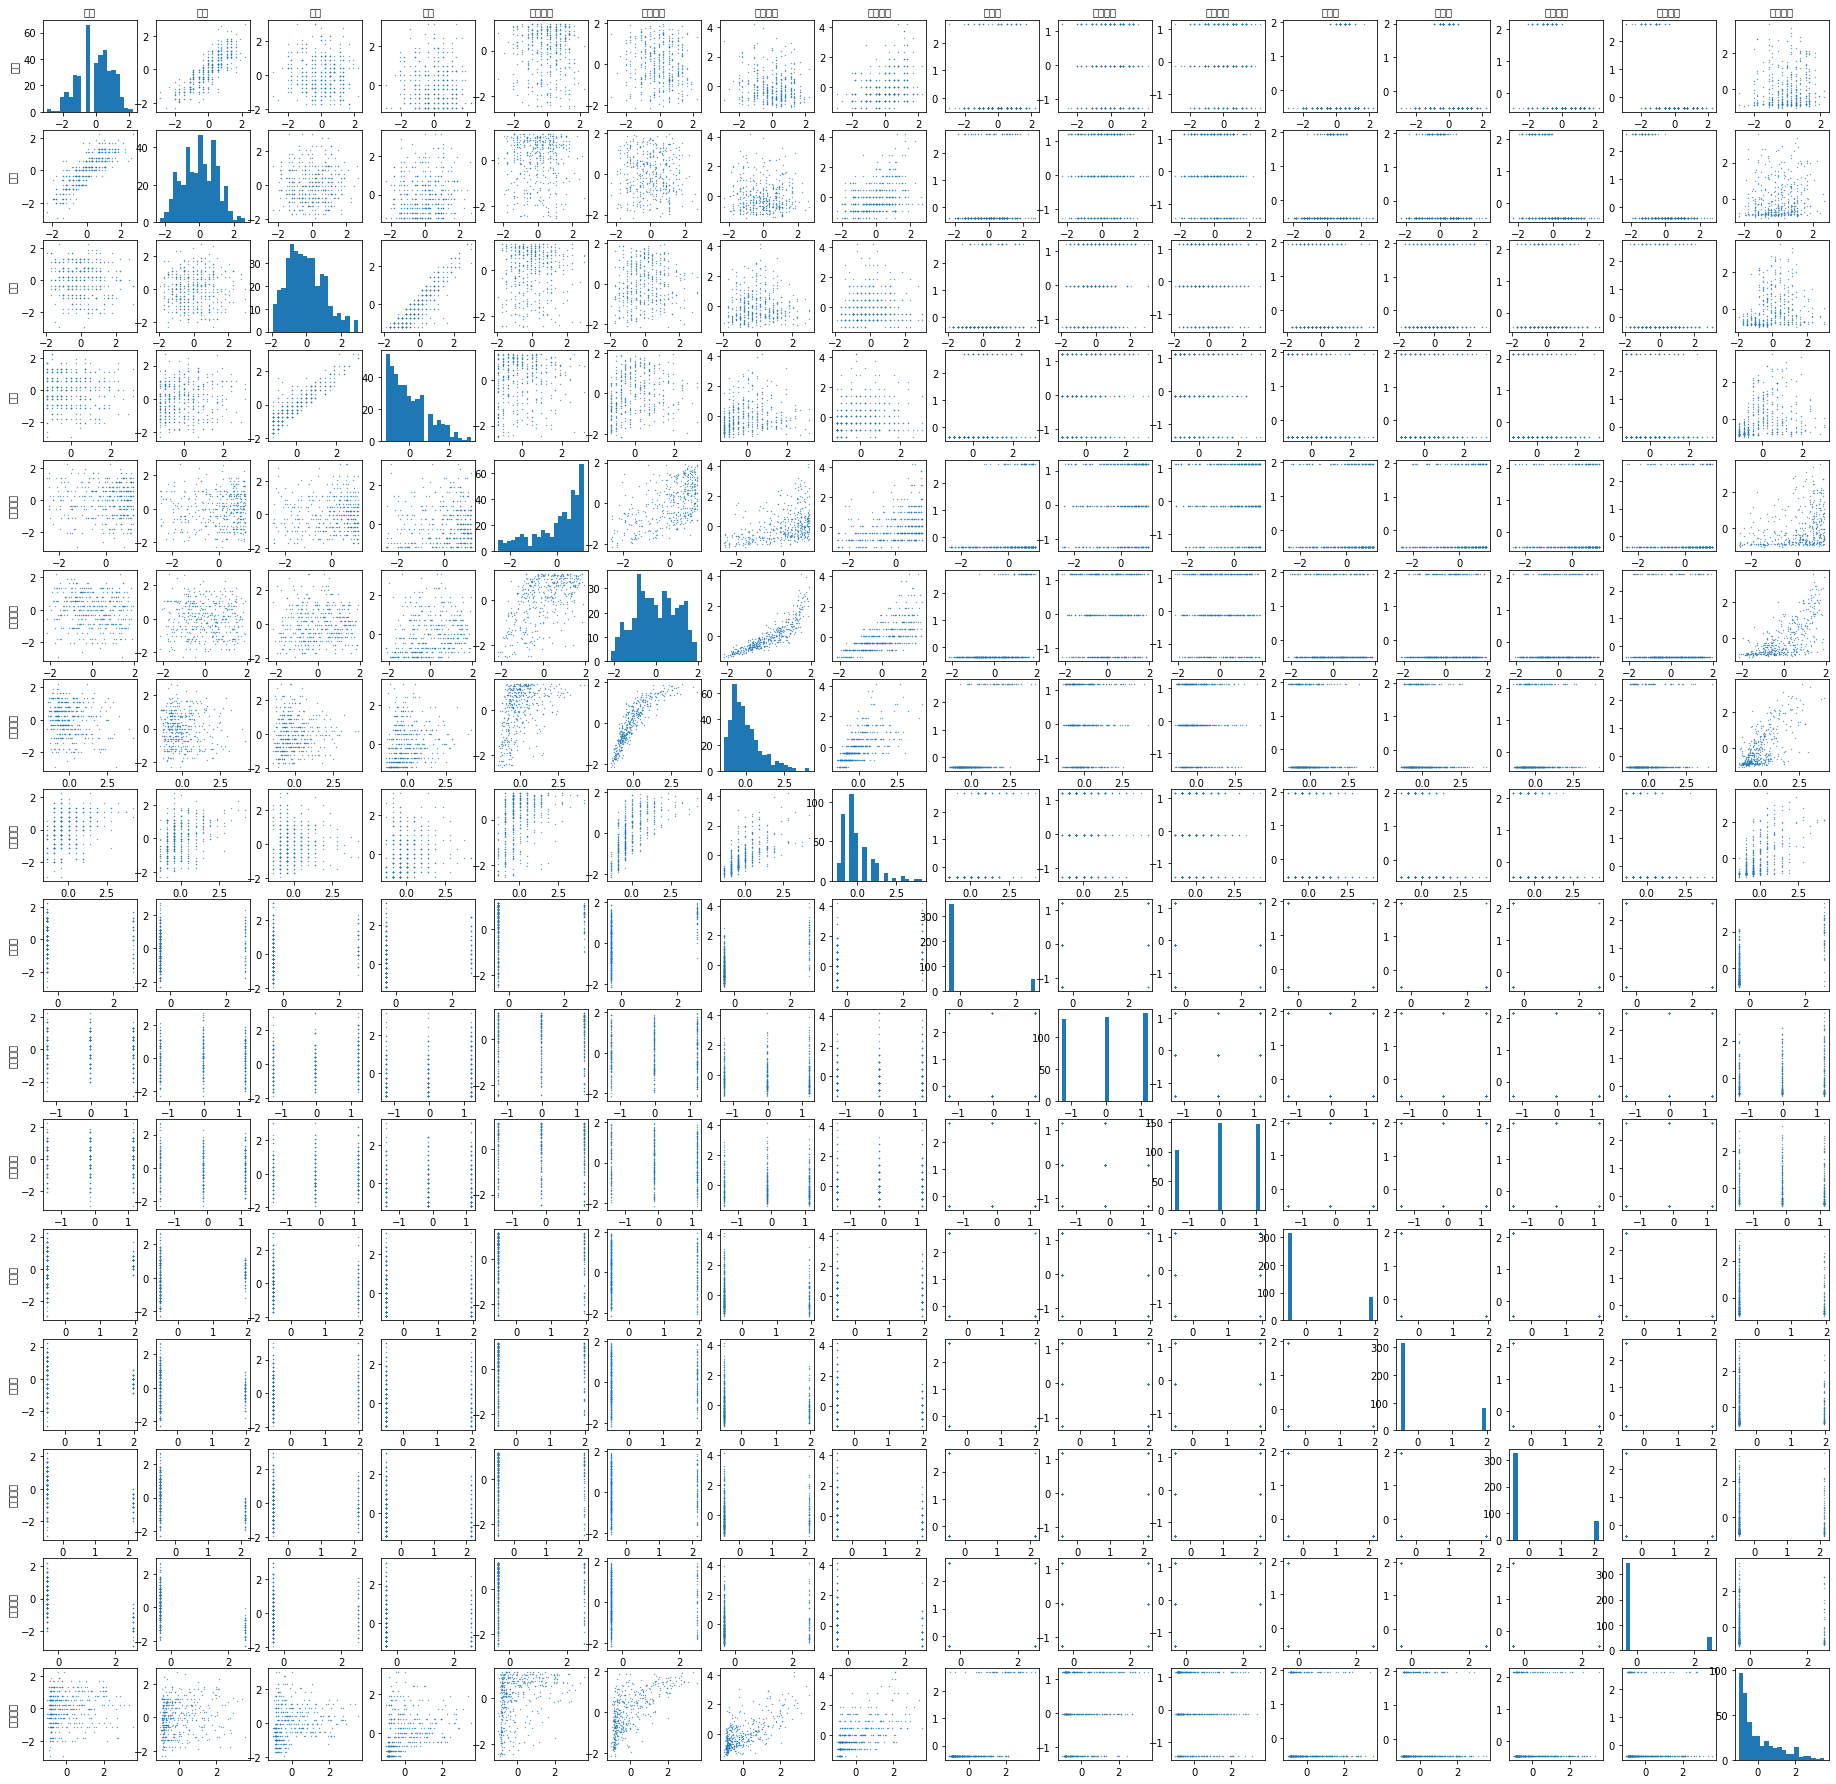

In [47]:
ana.overview()

绘制相关系数图  
从相关系数矩阵可以看出，球员身高、球员体重这两个变量，球员年龄、球龄这两个变量, 上场次数、场均时间、进攻能力、防守能力这四个变量之间存在明显的正相关性，而球员身高体重和他们是否是控球后卫，是否是小前锋有明显的负相关性。

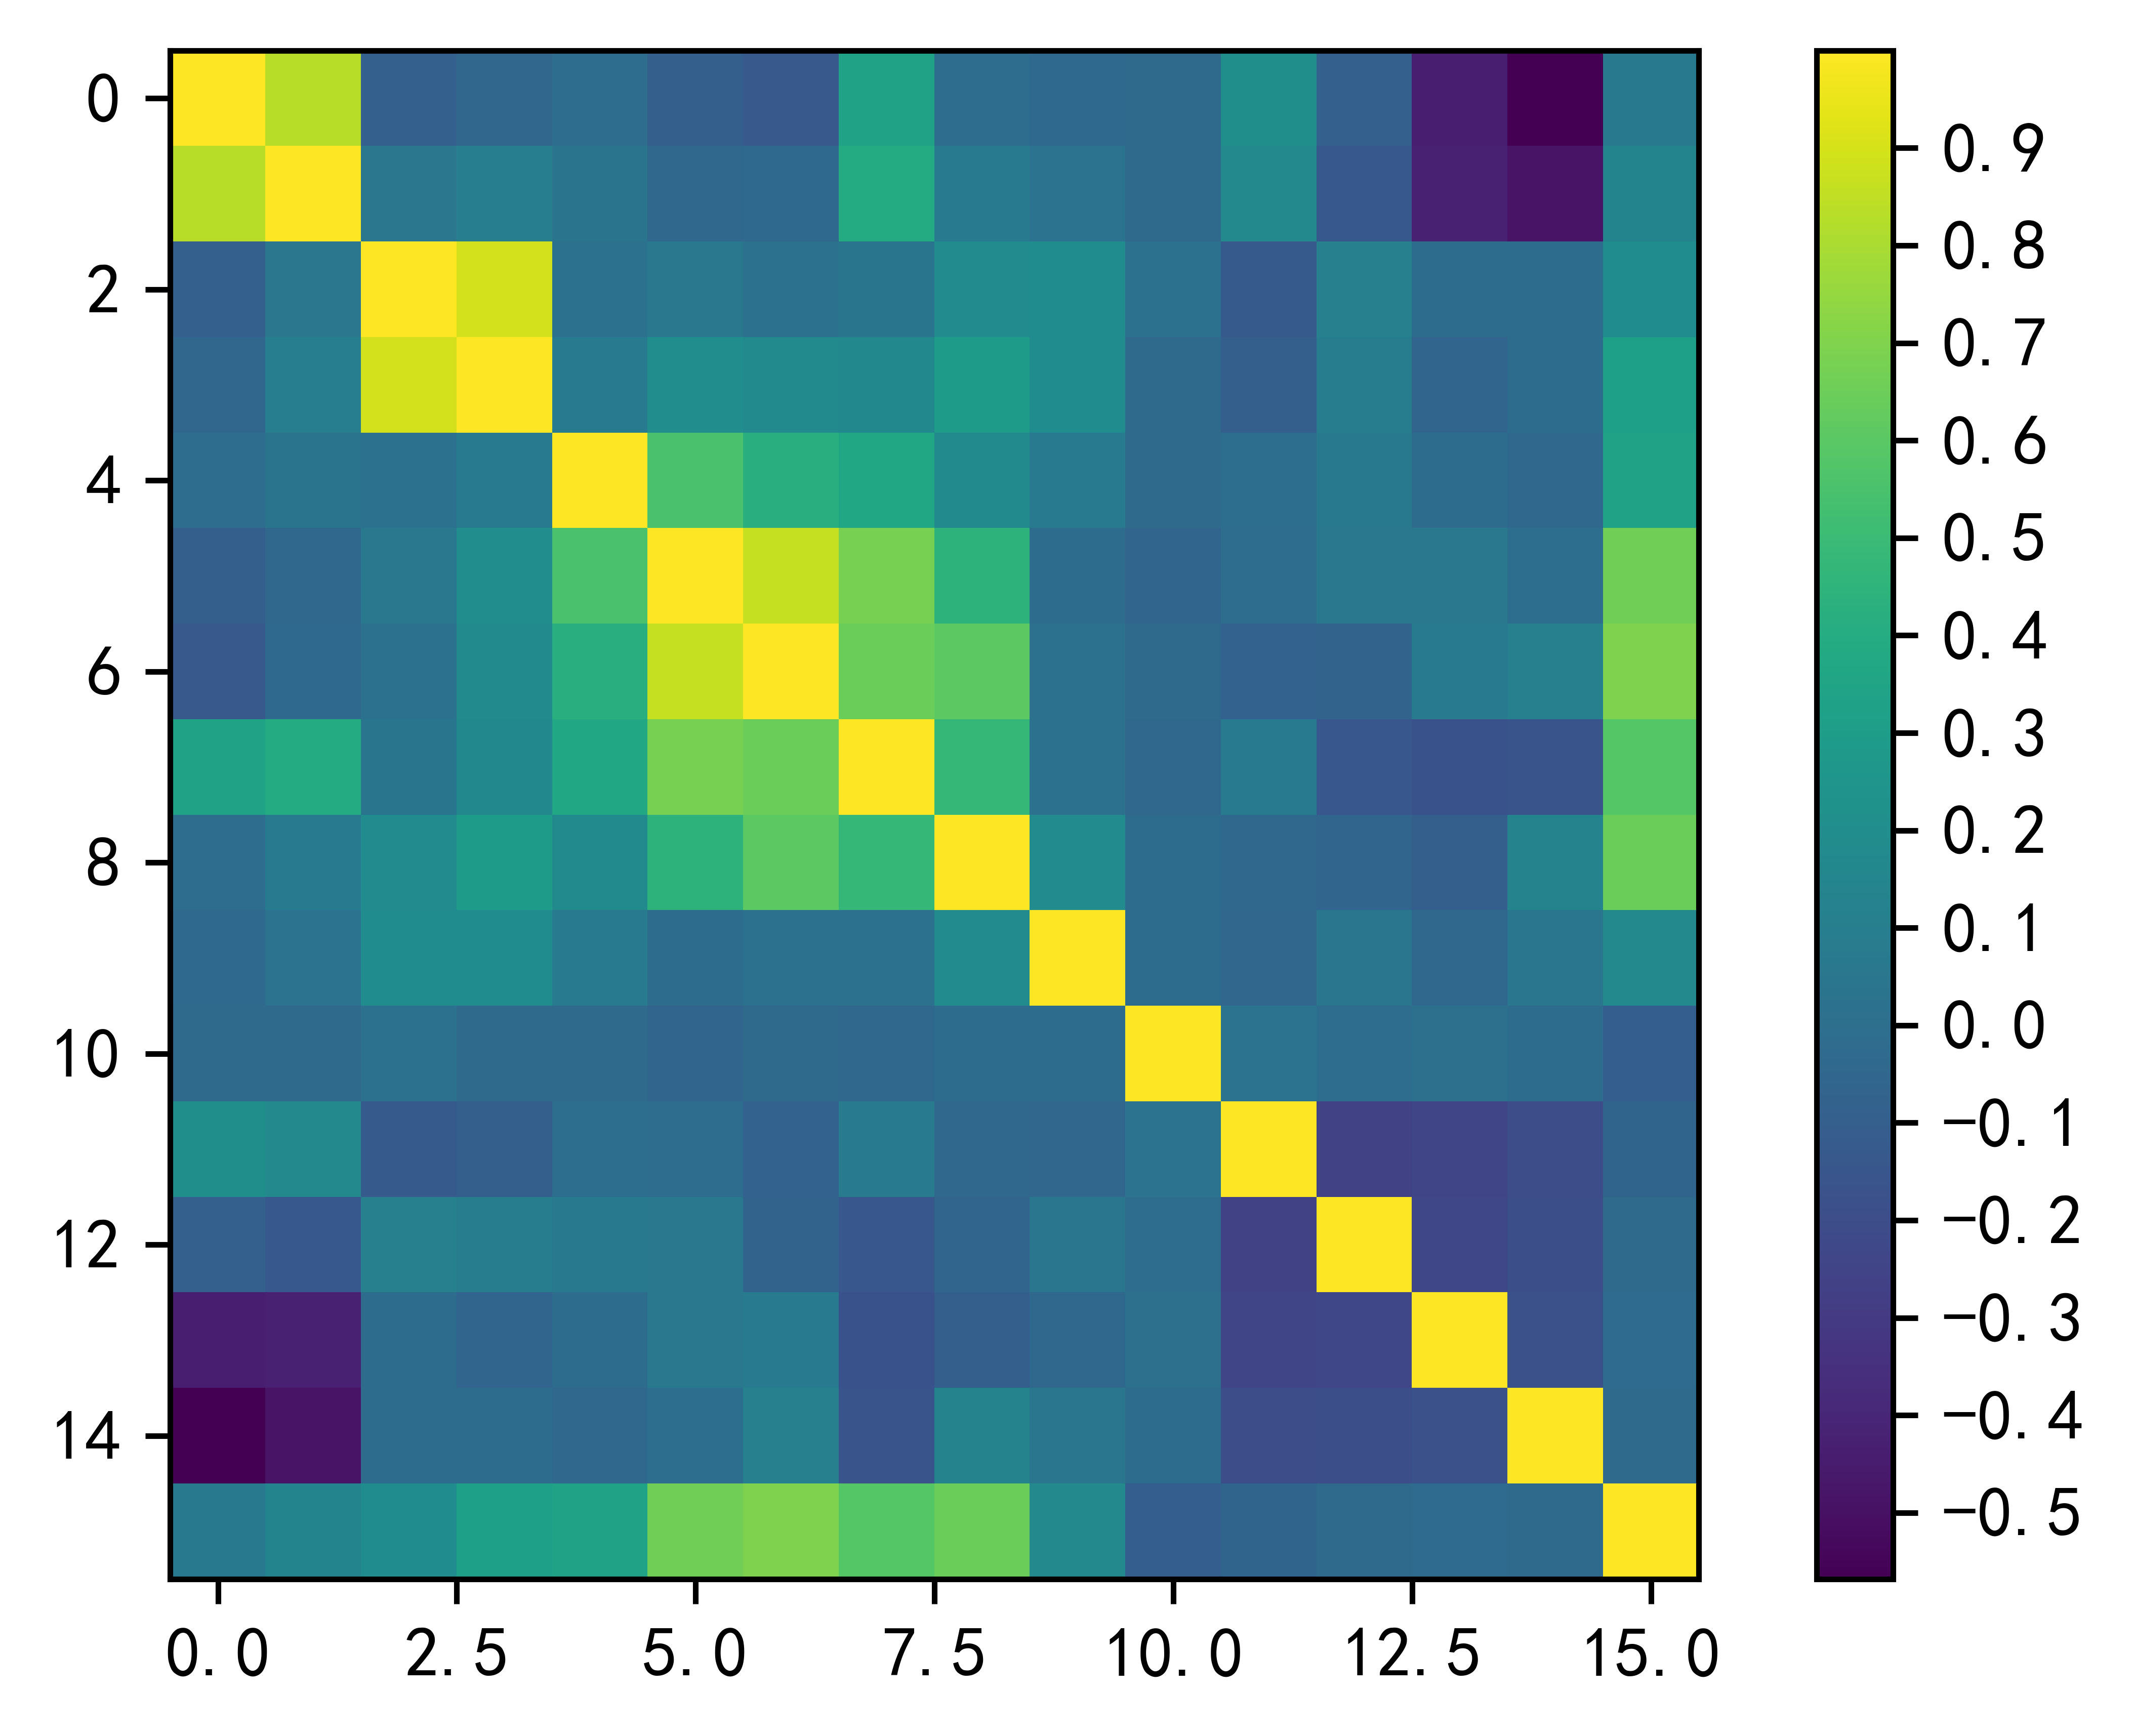

In [52]:
ana.plot_cor()

根据变量的p值可以看出，对于大部分变量（是否入选全明星、进攻能力、上场时间等），p值都小于0.05数据，这意味着他们和球员薪资存在明显的关系；但对于某些p值大于0.05的变量，他们并没有显示出明显的相关性，如球员所在的位置。

In [53]:
ana.anova()

             df      sum_sq     mean_sq           F        PR(>F)
身高          1.0    1.882151    1.882151    5.102631  2.445426e-02
体重          1.0    8.865462    8.865462   24.034824  1.402850e-06
年龄          1.0   12.122051   12.122051   32.863642  2.013175e-08
球龄          1.0   33.958419   33.958419   92.063408  1.137906e-19
上场次数        1.0   32.589759   32.589759   88.352886  5.183542e-19
场均时间        1.0  106.204690  106.204690  287.927590  1.675870e-48
进攻能力        1.0   27.196680   27.196680   73.731908  2.314016e-16
防守能力        1.0    1.309601    1.309601    3.550411  6.029179e-02
全明星         1.0   24.779720   24.779720   67.179379  3.816956e-15
球队胜率        1.0    3.200602    3.200602    8.677034  3.420343e-03
球队市值        1.0    1.795339    1.795339    4.867276  2.796681e-02
大前锋         1.0    0.740376    0.740376    2.007205  1.573706e-01
小前锋         1.0    0.256267    0.256267    0.694755  4.050741e-01
得分后卫        1.0    0.452115    0.452115    1.225713  2.689408e-01
控球后卫      

一般情况下，KMO>0.9 非常适合因子分析；0.8＜KMO＜0.9 适合；0.7 以上尚可，0.6 时效果很差，0.5 以下不适宜作因子分析。  
巴特利球形检验的统计计量数值较大，且对应的相伴概率值小于用户给定的显著性水平，因此应该拒绝零假设，认为自变量之间存在明显的相关性

In [54]:
ana.KMO()

KMO值： 0.48563
巴特利特球： 0.0


## linear reg

线性回归的β值

In [44]:
ana.linear_beta().T

,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,大前锋,小前锋,得分后卫,控球后卫
球员薪金,0.123279,0.001745,0.061414,0.04335,-0.008571,0.307953,0.231822,0.011391,0.328561,0.09361,-0.06639,-0.056633,-0.036077,0.008048,-0.042849


在线性回归的情况下绘制场均时间和球员薪资的散点图，同时加入线性回归预测曲线

Text(0, 0.5, '球员薪资')

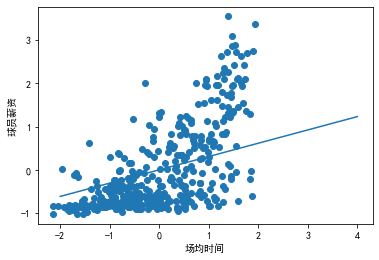

In [50]:
l=np.linspace(-2,4,100)
plt.scatter(ana.X['场均时间'],ana.y)
x=ana.linear_beta().loc['场均时间']
ll=np.linspace(-2*x,4*x,100)
plt.plot(l,ll)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel('场均时间')
plt.ylabel('球员薪资')

## ridge

取值为0-10的岭迹图

E:\anaconda\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'球员薪金_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


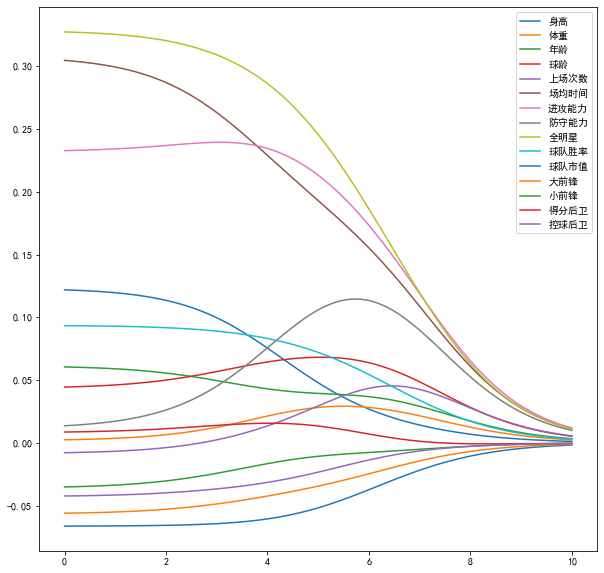

In [55]:
ana.plot_ridge(0,10)

In [76]:
ana.ridge(5).T

,身高,体重,年龄,球龄,上场次数,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值,大前锋,小前锋,得分后卫,控球后卫
球员薪金,0.047868,0.028201,0.039392,0.068197,0.029441,0.192926,0.21318,0.105915,0.245567,0.072031,-0.051747,-0.034438,-0.0107,0.013406,-0.02332


## PCA

碎石图及前i个主成分的贡献率

累积贡献率为：
前 1 个变量的累积贡献率为： 0.22230989053199604
前 2 个变量的累积贡献率为： 0.3994644844772379
前 3 个变量的累积贡献率为： 0.5302623384720988
前 4 个变量的累积贡献率为： 0.6151059406750992
前 5 个变量的累积贡献率为： 0.6955202910958931
前 6 个变量的累积贡献率为： 0.7625158112292371
前 7 个变量的累积贡献率为： 0.8248258243773066
前 8 个变量的累积贡献率为： 0.8841464234467116
前 9 个变量的累积贡献率为： 0.9309897205770303
前 10 个变量的累积贡献率为： 0.9595032373944449
前 11 个变量的累积贡献率为： 0.9749738126582908
前 12 个变量的累积贡献率为： 0.9848448248155446
前 13 个变量的累积贡献率为： 0.9907367222554494
前 14 个变量的累积贡献率为： 0.9964088537317495
前 15 个变量的累积贡献率为： 1.0000000000000002


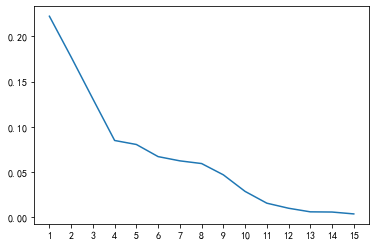

In [77]:
ana.plot_PCA()

In [56]:
ana.PCA(5)

array([[ 0.00517139],
       [ 0.03646347],
       [ 0.07146081],
       [ 0.10565734],
       [ 0.12506535],
       [ 0.19860442],
       [ 0.20247374],
       [ 0.18506694],
       [ 0.16873775],
       [ 0.03703154],
       [-0.01116288],
       [-0.00063533],
       [-0.02564718],
       [-0.0118448 ],
       [ 0.01104655]])

## evaluate

分别计算普通最小二乘，岭回归，主成分分析这三种方法的MSE和R2

In [139]:
ana1=analysis(data.drop(['球员薪金'],axis=1),data['球员薪金'],1)
ridge5=ana1.ridge(5)
lin=ana1.linear_beta()
p7=ana1.PCA(7)
print(ana1.R2(ridge5),ana1.R2(p7),ana1.R2(lin))
print(ana1.MSE(ridge5),ana1.MSE(p7),ana1.MSE(lin))

[[0.62630446]] [[0.62900707]] [[0.64117291]]
[[0.38437255]] [[0.38159272]] [[0.36907929]]


重新选择变量后，进行最小二乘拟合

In [140]:
ana3=analysis(data[['身高','球龄','场均时间','进攻能力','防守能力','全明星','球队胜率','球队市值']],data['球员薪金'],1)

In [69]:
a=ana3.linear_beta()
a.T

,身高,球龄,场均时间,进攻能力,防守能力,全明星,球队胜率,球队市值
球员薪金,0.131569,0.105072,0.279457,0.24889,0.01878,0.317244,0.093744,-0.065481


In [70]:
ana3.MSE(a)

array([[0.36728485]])

In [71]:
ana3.R2(a)

array([[0.64013505]])